In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
os.path.abspath(os.curdir)
os.chdir("..")
ML_FOLDER_PATH = os.path.abspath(os.curdir)
sys.path.append(ML_FOLDER_PATH)
import src.helpers as hlp
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()
from gensim.models import word2vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch
import torch.nn as nn

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
VECT_SIZE = 100

### Data processing

In [3]:
t_pos = pd.read_table("data/train_pos.txt", header=None, names=['tweet'], dtype=str,on_bad_lines='skip')
t_pos['label'] = 1
t_neg = pd.read_table("data/train_neg.txt", header=None, names=['tweet'], dtype=str,on_bad_lines='skip')
t_neg['label'] = 0
df = pd.concat((t_pos,t_neg))

In [4]:
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_stopwords(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_punct(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.add_space(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_white_space(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_words_digits(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.to_lower(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_specific_words(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_repeating_char(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_single_char(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.lemmatize(x))
df['tweet'] = df['tweet'].apply(lambda s: tweet_tokenizer.tokenize(s))

### Vectorization

In [5]:
X_train, X_test, y_train, y_test = train_test_split (df['tweet'], df['label'] , test_size=0.2)

In [6]:
w2c_model = word2vec.Word2Vec(sentences=X_train, vector_size=VECT_SIZE, window=5, min_count=1, workers=4)

In [7]:
def vectorize(model_train, dataset):
    words = set(model_train.wv.index_to_key)
    X_train_vect = np.array([np.array([model_train.wv[i] for i in ls if i in words])for ls in dataset])
    X_train_vect_avg = []
    for v in X_train_vect:
        if v.size:
            X_train_vect_avg.append(np.append(v.mean(axis=0),1))
        else:
            X_train_vect_avg.append(np.zeros(VECT_SIZE+1, dtype=float))
    return X_train_vect_avg


In [8]:
w2c_X_train_vect = vectorize(w2c_model, X_train)
w2c_X_test_vect = vectorize(w2c_model, X_test)

C:\Users\danie\AppData\Local\Temp\ipykernel_34292\3706557185.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([model_train.wv[i] for i in ls if i in words])for ls in dataset])


### Bernouilli Naive Bayes

In [10]:
from sklearn.naive_bayes import BernoulliNB
BNB = BernoulliNB()
BNB.fit(w2c_X_train_vect, y_train)

BernoulliNB()

In [12]:
y_pred = BNB.predict(w2c_X_test_vect)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.49      0.58     19742
           1       0.61      0.80      0.69     19652

    accuracy                           0.64     39394
   macro avg       0.66      0.64      0.63     39394
weighted avg       0.66      0.64      0.63     39394



### Support vector machine

In [9]:
LSVC = LinearSVC(verbose=1, max_iter=2000)
LSVC.fit(w2c_X_train_vect, y_train)

[LibLinear]

c:\Users\danie\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=2000, verbose=1)

In [10]:
y_pred = LSVC.predict(w2c_X_test_vect)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.73      0.74     19807
           1       0.73      0.75      0.74     19587

    accuracy                           0.74     39394
   macro avg       0.74      0.74      0.74     39394
weighted avg       0.74      0.74      0.74     39394



### Vectorization

We vectorize again with bigger dimension for the embeddings as it showed better results

In [11]:
VECT_SIZE = 200

In [12]:
w2c_model = word2vec.Word2Vec(sentences=X_train, vector_size=VECT_SIZE, window=5, min_count=1, workers=4)
w2c_X_train_vect = vectorize(w2c_model, X_train)
w2c_X_test_vect = vectorize(w2c_model, X_test)

C:\Users\danie\AppData\Local\Temp\ipykernel_21584\3706557185.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([model_train.wv[i] for i in ls if i in words])for ls in dataset])


### Neuronal Network

In [13]:
class TrainDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    
    def __getitem__(self, index):
        return self.y_data[index], self.X_data[index] 

    def __len__(self):
        return len(self.X_data)

In [14]:
train_data = TrainDataset(torch.FloatTensor(w2c_X_train_vect), torch.LongTensor(y_train.values))
test_data = TrainDataset(torch.FloatTensor(w2c_X_test_vect), torch.LongTensor(y_test.values))

C:\Users\danie\AppData\Local\Temp\ipykernel_21584\1166895078.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  train_data = TrainDataset(torch.FloatTensor(w2c_X_train_vect), torch.LongTensor(y_train.values))


In [15]:
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer):
        train_loss, correct = 0,0
        for y_batch, X_batch in tqdm(dataloader):

                pred = model(X_batch)
                loss = loss_fn(pred, y_batch)

                train_loss += loss.item()
                correct += (pred.argmax(1) == y_batch).type(torch.float).sum().item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        train_loss /= len(dataloader)
        correct /= len(dataloader.dataset)
        print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")
        return train_loss, correct

In [17]:
def test_loop(dataloader, model, loss_fn):
    test_loss, correct = 0,0
    with torch.no_grad():
        for y, X in dataloader:

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct



In [18]:
def train(model, train_loader, valid_loader, num_epochs, learning_rate):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_accs, test_accs = [], [], []
    for epoch in range(num_epochs):
        print(f"Epoch : {epoch+1}\n")
        train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer)
        test_loss, test_acc = test_loop(test_loader, model, loss_fn)
        losses.append(float(train_loss))
        train_accs.append(train_acc)
        test_accs.append(test_acc)
    
    plt.title("Training")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(train_accs, label="Train")
    plt.plot(test_accs, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()



In [19]:
model = nn.Sequential(nn.Linear(VECT_SIZE+1, 200),
                        nn.Sigmoid(),
                        nn.Dropout(p=0.5),
                        nn.Linear(200, 50),
                        nn.Sigmoid(),
                        nn.Dropout(p=0.5),
                        nn.Linear(50, 2),
                        nn.Softmax(1))

Epoch : 1



100%|██████████| 2463/2463 [00:13<00:00, 187.16it/s]


Train Error: 
 Accuracy: 72.4%, Avg loss: 0.566276 

Test Error: 
 Accuracy: 73.5%, Avg loss: 0.558904 

Epoch : 2



100%|██████████| 2463/2463 [00:12<00:00, 200.22it/s]


Train Error: 
 Accuracy: 73.6%, Avg loss: 0.556162 

Test Error: 
 Accuracy: 73.4%, Avg loss: 0.555286 

Epoch : 3



100%|██████████| 2463/2463 [00:13<00:00, 188.57it/s]


Train Error: 
 Accuracy: 73.7%, Avg loss: 0.554842 

Test Error: 
 Accuracy: 73.5%, Avg loss: 0.553935 

Epoch : 4



100%|██████████| 2463/2463 [00:13<00:00, 184.61it/s]


Train Error: 
 Accuracy: 74.0%, Avg loss: 0.553858 

Test Error: 
 Accuracy: 73.6%, Avg loss: 0.558623 

Epoch : 5



100%|██████████| 2463/2463 [00:16<00:00, 144.97it/s]


Train Error: 
 Accuracy: 74.0%, Avg loss: 0.552580 

Test Error: 
 Accuracy: 73.8%, Avg loss: 0.556992 

Epoch : 6



100%|██████████| 2463/2463 [00:12<00:00, 201.90it/s]


Train Error: 
 Accuracy: 73.9%, Avg loss: 0.553154 

Test Error: 
 Accuracy: 74.2%, Avg loss: 0.551376 

Epoch : 7



100%|██████████| 2463/2463 [00:12<00:00, 200.63it/s]


Train Error: 
 Accuracy: 74.1%, Avg loss: 0.552271 

Test Error: 
 Accuracy: 73.8%, Avg loss: 0.555452 

Epoch : 8



100%|██████████| 2463/2463 [00:13<00:00, 188.82it/s]


Train Error: 
 Accuracy: 74.1%, Avg loss: 0.552506 

Test Error: 
 Accuracy: 73.8%, Avg loss: 0.555078 

Epoch : 9



100%|██████████| 2463/2463 [00:12<00:00, 203.89it/s]


Train Error: 
 Accuracy: 74.1%, Avg loss: 0.551417 

Test Error: 
 Accuracy: 74.1%, Avg loss: 0.553789 

Epoch : 10



100%|██████████| 2463/2463 [00:12<00:00, 196.82it/s]


Train Error: 
 Accuracy: 74.3%, Avg loss: 0.550846 

Test Error: 
 Accuracy: 73.9%, Avg loss: 0.554018 

Epoch : 11



100%|██████████| 2463/2463 [00:11<00:00, 214.92it/s]


Train Error: 
 Accuracy: 74.3%, Avg loss: 0.550825 

Test Error: 
 Accuracy: 74.2%, Avg loss: 0.551568 

Epoch : 12



100%|██████████| 2463/2463 [00:12<00:00, 194.09it/s]


Train Error: 
 Accuracy: 74.3%, Avg loss: 0.550820 

Test Error: 
 Accuracy: 73.9%, Avg loss: 0.554718 

Epoch : 13



100%|██████████| 2463/2463 [00:15<00:00, 159.24it/s]


Train Error: 
 Accuracy: 74.3%, Avg loss: 0.550796 

Test Error: 
 Accuracy: 73.5%, Avg loss: 0.552043 

Epoch : 14



100%|██████████| 2463/2463 [00:12<00:00, 198.36it/s]


Train Error: 
 Accuracy: 74.3%, Avg loss: 0.550505 

Test Error: 
 Accuracy: 73.8%, Avg loss: 0.555731 

Epoch : 15



100%|██████████| 2463/2463 [00:12<00:00, 191.43it/s]


Train Error: 
 Accuracy: 74.2%, Avg loss: 0.550857 

Test Error: 
 Accuracy: 74.1%, Avg loss: 0.552750 

Epoch : 16



100%|██████████| 2463/2463 [00:11<00:00, 208.21it/s]


Train Error: 
 Accuracy: 74.2%, Avg loss: 0.551397 

Test Error: 
 Accuracy: 73.9%, Avg loss: 0.552941 

Epoch : 17



100%|██████████| 2463/2463 [00:13<00:00, 188.14it/s]


Train Error: 
 Accuracy: 74.3%, Avg loss: 0.550649 

Test Error: 
 Accuracy: 74.1%, Avg loss: 0.554027 

Epoch : 18



100%|██████████| 2463/2463 [00:11<00:00, 214.78it/s]


Train Error: 
 Accuracy: 74.1%, Avg loss: 0.552219 

Test Error: 
 Accuracy: 73.9%, Avg loss: 0.555144 

Epoch : 19



100%|██████████| 2463/2463 [00:12<00:00, 204.74it/s]


Train Error: 
 Accuracy: 74.2%, Avg loss: 0.550653 

Test Error: 
 Accuracy: 74.4%, Avg loss: 0.549460 

Epoch : 20



100%|██████████| 2463/2463 [00:11<00:00, 211.48it/s]


Train Error: 
 Accuracy: 74.4%, Avg loss: 0.549605 

Test Error: 
 Accuracy: 74.1%, Avg loss: 0.551197 

Epoch : 21



100%|██████████| 2463/2463 [00:14<00:00, 169.39it/s]


Train Error: 
 Accuracy: 74.3%, Avg loss: 0.550119 

Test Error: 
 Accuracy: 74.0%, Avg loss: 0.551078 

Epoch : 22



100%|██████████| 2463/2463 [00:11<00:00, 212.97it/s]


Train Error: 
 Accuracy: 74.5%, Avg loss: 0.548867 

Test Error: 
 Accuracy: 74.0%, Avg loss: 0.552227 

Epoch : 23



100%|██████████| 2463/2463 [00:11<00:00, 208.41it/s]


Train Error: 
 Accuracy: 74.4%, Avg loss: 0.549262 

Test Error: 
 Accuracy: 74.2%, Avg loss: 0.551851 

Epoch : 24



100%|██████████| 2463/2463 [00:13<00:00, 183.97it/s]


Train Error: 
 Accuracy: 74.4%, Avg loss: 0.549586 

Test Error: 
 Accuracy: 74.1%, Avg loss: 0.552222 

Epoch : 25



100%|██████████| 2463/2463 [00:13<00:00, 183.47it/s]


Train Error: 
 Accuracy: 74.3%, Avg loss: 0.549414 

Test Error: 
 Accuracy: 73.9%, Avg loss: 0.553876 

Epoch : 26



100%|██████████| 2463/2463 [00:12<00:00, 191.72it/s]


Train Error: 
 Accuracy: 74.3%, Avg loss: 0.550168 

Test Error: 
 Accuracy: 74.1%, Avg loss: 0.552823 

Epoch : 27



100%|██████████| 2463/2463 [00:12<00:00, 192.34it/s]


Train Error: 
 Accuracy: 74.5%, Avg loss: 0.548604 

Test Error: 
 Accuracy: 74.0%, Avg loss: 0.552040 

Epoch : 28



100%|██████████| 2463/2463 [00:12<00:00, 191.52it/s]


Train Error: 
 Accuracy: 74.4%, Avg loss: 0.548837 

Test Error: 
 Accuracy: 74.2%, Avg loss: 0.551131 

Epoch : 29



100%|██████████| 2463/2463 [00:14<00:00, 167.82it/s]


Train Error: 
 Accuracy: 74.3%, Avg loss: 0.549945 

Test Error: 
 Accuracy: 74.4%, Avg loss: 0.551672 

Epoch : 30



100%|██████████| 2463/2463 [00:12<00:00, 202.68it/s]


Train Error: 
 Accuracy: 74.5%, Avg loss: 0.549534 

Test Error: 
 Accuracy: 74.3%, Avg loss: 0.550272 

Epoch : 31



100%|██████████| 2463/2463 [00:13<00:00, 182.26it/s]


Train Error: 
 Accuracy: 74.4%, Avg loss: 0.548327 

Test Error: 
 Accuracy: 74.2%, Avg loss: 0.552397 

Epoch : 32



100%|██████████| 2463/2463 [00:15<00:00, 164.07it/s]


Train Error: 
 Accuracy: 74.5%, Avg loss: 0.548202 

Test Error: 
 Accuracy: 74.4%, Avg loss: 0.548576 

Epoch : 33



100%|██████████| 2463/2463 [00:11<00:00, 205.98it/s]


Train Error: 
 Accuracy: 74.3%, Avg loss: 0.548768 

Test Error: 
 Accuracy: 73.5%, Avg loss: 0.553924 

Epoch : 34



100%|██████████| 2463/2463 [00:12<00:00, 204.24it/s]


Train Error: 
 Accuracy: 74.2%, Avg loss: 0.550045 

Test Error: 
 Accuracy: 73.9%, Avg loss: 0.553214 

Epoch : 35



100%|██████████| 2463/2463 [00:16<00:00, 150.20it/s]


Train Error: 
 Accuracy: 74.3%, Avg loss: 0.549348 

Test Error: 
 Accuracy: 74.1%, Avg loss: 0.551587 

Epoch : 36



100%|██████████| 2463/2463 [00:15<00:00, 158.18it/s]


Train Error: 
 Accuracy: 74.4%, Avg loss: 0.548828 

Test Error: 
 Accuracy: 74.0%, Avg loss: 0.551125 

Epoch : 37



100%|██████████| 2463/2463 [00:12<00:00, 203.92it/s]


Train Error: 
 Accuracy: 74.3%, Avg loss: 0.549570 

Test Error: 
 Accuracy: 74.4%, Avg loss: 0.550031 

Epoch : 38



100%|██████████| 2463/2463 [00:17<00:00, 141.33it/s]


Train Error: 
 Accuracy: 74.5%, Avg loss: 0.548822 

Test Error: 
 Accuracy: 73.9%, Avg loss: 0.550803 

Epoch : 39



100%|██████████| 2463/2463 [00:11<00:00, 209.38it/s]


Train Error: 
 Accuracy: 74.3%, Avg loss: 0.549726 

Test Error: 
 Accuracy: 74.3%, Avg loss: 0.551570 

Epoch : 40



100%|██████████| 2463/2463 [00:12<00:00, 193.19it/s]


Train Error: 
 Accuracy: 74.7%, Avg loss: 0.547244 

Test Error: 
 Accuracy: 73.8%, Avg loss: 0.554242 

Epoch : 41



100%|██████████| 2463/2463 [00:12<00:00, 198.85it/s]


Train Error: 
 Accuracy: 74.7%, Avg loss: 0.547770 

Test Error: 
 Accuracy: 74.1%, Avg loss: 0.552413 

Epoch : 42



100%|██████████| 2463/2463 [00:12<00:00, 193.90it/s]


Train Error: 
 Accuracy: 74.5%, Avg loss: 0.548111 

Test Error: 
 Accuracy: 74.0%, Avg loss: 0.552420 

Epoch : 43



100%|██████████| 2463/2463 [00:15<00:00, 155.55it/s]


Train Error: 
 Accuracy: 74.5%, Avg loss: 0.548295 

Test Error: 
 Accuracy: 74.5%, Avg loss: 0.551040 

Epoch : 44



100%|██████████| 2463/2463 [00:14<00:00, 172.79it/s]


Train Error: 
 Accuracy: 74.7%, Avg loss: 0.547155 

Test Error: 
 Accuracy: 74.1%, Avg loss: 0.551172 

Epoch : 45



100%|██████████| 2463/2463 [00:13<00:00, 182.48it/s]


Train Error: 
 Accuracy: 74.6%, Avg loss: 0.547951 

Test Error: 
 Accuracy: 74.5%, Avg loss: 0.550950 

Epoch : 46



100%|██████████| 2463/2463 [00:15<00:00, 155.51it/s]


Train Error: 
 Accuracy: 74.5%, Avg loss: 0.548376 

Test Error: 
 Accuracy: 74.2%, Avg loss: 0.552417 

Epoch : 47



100%|██████████| 2463/2463 [00:12<00:00, 204.20it/s]


Train Error: 
 Accuracy: 74.4%, Avg loss: 0.549913 

Test Error: 
 Accuracy: 74.2%, Avg loss: 0.550929 

Epoch : 48



100%|██████████| 2463/2463 [00:13<00:00, 178.00it/s]


Train Error: 
 Accuracy: 74.5%, Avg loss: 0.548784 

Test Error: 
 Accuracy: 74.2%, Avg loss: 0.549566 

Epoch : 49



100%|██████████| 2463/2463 [00:11<00:00, 209.28it/s]


Train Error: 
 Accuracy: 74.5%, Avg loss: 0.548762 

Test Error: 
 Accuracy: 74.4%, Avg loss: 0.552535 

Epoch : 50



100%|██████████| 2463/2463 [00:11<00:00, 207.89it/s]


Train Error: 
 Accuracy: 74.4%, Avg loss: 0.549147 

Test Error: 
 Accuracy: 74.4%, Avg loss: 0.551309 

Epoch : 51



100%|██████████| 2463/2463 [00:10<00:00, 226.05it/s]


Train Error: 
 Accuracy: 74.6%, Avg loss: 0.548191 

Test Error: 
 Accuracy: 73.9%, Avg loss: 0.551693 

Epoch : 52



100%|██████████| 2463/2463 [00:10<00:00, 224.10it/s]


Train Error: 
 Accuracy: 74.6%, Avg loss: 0.548359 

Test Error: 
 Accuracy: 73.9%, Avg loss: 0.550879 

Epoch : 53



100%|██████████| 2463/2463 [00:10<00:00, 230.94it/s]


Train Error: 
 Accuracy: 74.6%, Avg loss: 0.547724 

Test Error: 
 Accuracy: 74.4%, Avg loss: 0.549771 

Epoch : 54



100%|██████████| 2463/2463 [00:10<00:00, 226.82it/s]


Train Error: 
 Accuracy: 74.5%, Avg loss: 0.548182 

Test Error: 
 Accuracy: 74.1%, Avg loss: 0.551101 

Epoch : 55



100%|██████████| 2463/2463 [00:11<00:00, 206.88it/s]


Train Error: 
 Accuracy: 74.5%, Avg loss: 0.547499 

Test Error: 
 Accuracy: 73.8%, Avg loss: 0.551009 

Epoch : 56



100%|██████████| 2463/2463 [00:11<00:00, 216.58it/s]


Train Error: 
 Accuracy: 74.4%, Avg loss: 0.548838 

Test Error: 
 Accuracy: 74.3%, Avg loss: 0.549343 

Epoch : 57



100%|██████████| 2463/2463 [00:10<00:00, 238.23it/s]


Train Error: 
 Accuracy: 74.7%, Avg loss: 0.547068 

Test Error: 
 Accuracy: 74.3%, Avg loss: 0.551547 

Epoch : 58



100%|██████████| 2463/2463 [00:10<00:00, 233.63it/s]


Train Error: 
 Accuracy: 74.6%, Avg loss: 0.547870 

Test Error: 
 Accuracy: 73.7%, Avg loss: 0.553417 

Epoch : 59



100%|██████████| 2463/2463 [00:09<00:00, 261.22it/s]


Train Error: 
 Accuracy: 74.6%, Avg loss: 0.548462 

Test Error: 
 Accuracy: 74.6%, Avg loss: 0.548650 

Epoch : 60



100%|██████████| 2463/2463 [00:09<00:00, 263.83it/s]


Train Error: 
 Accuracy: 74.7%, Avg loss: 0.547228 

Test Error: 
 Accuracy: 74.2%, Avg loss: 0.552373 

Epoch : 61



100%|██████████| 2463/2463 [00:09<00:00, 254.42it/s]


Train Error: 
 Accuracy: 74.5%, Avg loss: 0.548464 

Test Error: 
 Accuracy: 74.2%, Avg loss: 0.551225 

Epoch : 62



100%|██████████| 2463/2463 [00:09<00:00, 263.83it/s]


Train Error: 
 Accuracy: 74.6%, Avg loss: 0.548227 

Test Error: 
 Accuracy: 74.0%, Avg loss: 0.552140 

Epoch : 63



100%|██████████| 2463/2463 [00:11<00:00, 219.31it/s]


Train Error: 
 Accuracy: 74.6%, Avg loss: 0.547483 

Test Error: 
 Accuracy: 74.0%, Avg loss: 0.549323 

Epoch : 64



100%|██████████| 2463/2463 [00:09<00:00, 248.08it/s]


Train Error: 
 Accuracy: 74.6%, Avg loss: 0.547049 

Test Error: 
 Accuracy: 74.2%, Avg loss: 0.550041 

Epoch : 65



100%|██████████| 2463/2463 [00:09<00:00, 260.62it/s]


Train Error: 
 Accuracy: 74.7%, Avg loss: 0.547264 

Test Error: 
 Accuracy: 74.1%, Avg loss: 0.550933 

Epoch : 66



100%|██████████| 2463/2463 [00:11<00:00, 218.87it/s]


Train Error: 
 Accuracy: 74.5%, Avg loss: 0.547485 

Test Error: 
 Accuracy: 74.0%, Avg loss: 0.552007 

Epoch : 67



100%|██████████| 2463/2463 [00:11<00:00, 216.67it/s]


Train Error: 
 Accuracy: 74.5%, Avg loss: 0.547887 

Test Error: 
 Accuracy: 74.1%, Avg loss: 0.550313 

Epoch : 68



100%|██████████| 2463/2463 [00:10<00:00, 229.76it/s]


Train Error: 
 Accuracy: 74.4%, Avg loss: 0.548886 

Test Error: 
 Accuracy: 74.2%, Avg loss: 0.549271 

Epoch : 69



100%|██████████| 2463/2463 [00:12<00:00, 202.38it/s]


Train Error: 
 Accuracy: 74.5%, Avg loss: 0.547711 

Test Error: 
 Accuracy: 74.3%, Avg loss: 0.549306 

Epoch : 70



100%|██████████| 2463/2463 [00:12<00:00, 190.93it/s]


Train Error: 
 Accuracy: 74.7%, Avg loss: 0.547104 

Test Error: 
 Accuracy: 74.3%, Avg loss: 0.551399 

Epoch : 71



100%|██████████| 2463/2463 [00:13<00:00, 184.04it/s]


Train Error: 
 Accuracy: 74.6%, Avg loss: 0.547704 

Test Error: 
 Accuracy: 74.7%, Avg loss: 0.548931 

Epoch : 72



100%|██████████| 2463/2463 [00:11<00:00, 218.27it/s]


Train Error: 
 Accuracy: 74.7%, Avg loss: 0.547143 

Test Error: 
 Accuracy: 74.0%, Avg loss: 0.553356 

Epoch : 73



100%|██████████| 2463/2463 [00:11<00:00, 218.49it/s]


Train Error: 
 Accuracy: 74.7%, Avg loss: 0.546599 

Test Error: 
 Accuracy: 74.4%, Avg loss: 0.550428 

Epoch : 74



100%|██████████| 2463/2463 [00:10<00:00, 226.40it/s]


Train Error: 
 Accuracy: 74.4%, Avg loss: 0.548605 

Test Error: 
 Accuracy: 74.2%, Avg loss: 0.552005 

Epoch : 75



100%|██████████| 2463/2463 [00:10<00:00, 236.96it/s]


Train Error: 
 Accuracy: 74.4%, Avg loss: 0.548643 

Test Error: 
 Accuracy: 73.8%, Avg loss: 0.552299 

Epoch : 76



100%|██████████| 2463/2463 [00:14<00:00, 166.22it/s]


Train Error: 
 Accuracy: 74.4%, Avg loss: 0.548161 

Test Error: 
 Accuracy: 74.1%, Avg loss: 0.550758 

Epoch : 77



100%|██████████| 2463/2463 [00:11<00:00, 215.87it/s]


Train Error: 
 Accuracy: 74.5%, Avg loss: 0.548280 

Test Error: 
 Accuracy: 74.2%, Avg loss: 0.551085 

Epoch : 78



100%|██████████| 2463/2463 [00:10<00:00, 229.75it/s]


Train Error: 
 Accuracy: 74.7%, Avg loss: 0.546862 

Test Error: 
 Accuracy: 74.2%, Avg loss: 0.553261 

Epoch : 79



100%|██████████| 2463/2463 [00:12<00:00, 201.07it/s]


Train Error: 
 Accuracy: 74.6%, Avg loss: 0.547386 

Test Error: 
 Accuracy: 74.2%, Avg loss: 0.549352 

Epoch : 80



100%|██████████| 2463/2463 [00:11<00:00, 223.78it/s]


Train Error: 
 Accuracy: 74.6%, Avg loss: 0.547670 

Test Error: 
 Accuracy: 74.3%, Avg loss: 0.551577 

Epoch : 81



100%|██████████| 2463/2463 [00:12<00:00, 198.20it/s]


Train Error: 
 Accuracy: 74.6%, Avg loss: 0.547483 

Test Error: 
 Accuracy: 74.3%, Avg loss: 0.550454 

Epoch : 82



100%|██████████| 2463/2463 [00:11<00:00, 209.44it/s]


Train Error: 
 Accuracy: 74.7%, Avg loss: 0.547260 

Test Error: 
 Accuracy: 74.3%, Avg loss: 0.550984 

Epoch : 83



100%|██████████| 2463/2463 [00:11<00:00, 212.24it/s]


Train Error: 
 Accuracy: 74.5%, Avg loss: 0.547453 

Test Error: 
 Accuracy: 74.2%, Avg loss: 0.551517 

Epoch : 84



100%|██████████| 2463/2463 [00:10<00:00, 227.75it/s]


Train Error: 
 Accuracy: 74.7%, Avg loss: 0.547348 

Test Error: 
 Accuracy: 73.9%, Avg loss: 0.552916 

Epoch : 85



100%|██████████| 2463/2463 [00:11<00:00, 213.27it/s]


Train Error: 
 Accuracy: 74.4%, Avg loss: 0.549090 

Test Error: 
 Accuracy: 73.7%, Avg loss: 0.555258 

Epoch : 86



100%|██████████| 2463/2463 [00:11<00:00, 209.81it/s]


Train Error: 
 Accuracy: 74.6%, Avg loss: 0.547362 

Test Error: 
 Accuracy: 74.1%, Avg loss: 0.552297 

Epoch : 87



100%|██████████| 2463/2463 [00:10<00:00, 231.30it/s]


Train Error: 
 Accuracy: 74.6%, Avg loss: 0.547130 

Test Error: 
 Accuracy: 74.4%, Avg loss: 0.551076 

Epoch : 88



100%|██████████| 2463/2463 [00:10<00:00, 231.43it/s]


Train Error: 
 Accuracy: 74.5%, Avg loss: 0.548764 

Test Error: 
 Accuracy: 74.1%, Avg loss: 0.551838 

Epoch : 89



100%|██████████| 2463/2463 [00:10<00:00, 231.56it/s]


Train Error: 
 Accuracy: 74.8%, Avg loss: 0.546840 

Test Error: 
 Accuracy: 74.4%, Avg loss: 0.551108 

Epoch : 90



100%|██████████| 2463/2463 [00:10<00:00, 230.32it/s]


Train Error: 
 Accuracy: 74.7%, Avg loss: 0.547133 

Test Error: 
 Accuracy: 74.4%, Avg loss: 0.551265 

Epoch : 91



100%|██████████| 2463/2463 [00:11<00:00, 211.55it/s]


Train Error: 
 Accuracy: 74.7%, Avg loss: 0.547509 

Test Error: 
 Accuracy: 74.1%, Avg loss: 0.551224 

Epoch : 92



100%|██████████| 2463/2463 [00:08<00:00, 275.72it/s]


Train Error: 
 Accuracy: 74.9%, Avg loss: 0.546223 

Test Error: 
 Accuracy: 74.5%, Avg loss: 0.551024 

Epoch : 93



100%|██████████| 2463/2463 [00:08<00:00, 277.21it/s]


Train Error: 
 Accuracy: 74.8%, Avg loss: 0.546381 

Test Error: 
 Accuracy: 74.4%, Avg loss: 0.548165 

Epoch : 94



100%|██████████| 2463/2463 [00:09<00:00, 269.19it/s]


Train Error: 
 Accuracy: 74.8%, Avg loss: 0.546555 

Test Error: 
 Accuracy: 74.1%, Avg loss: 0.550669 

Epoch : 95



100%|██████████| 2463/2463 [00:09<00:00, 248.55it/s]


Train Error: 
 Accuracy: 74.7%, Avg loss: 0.546894 

Test Error: 
 Accuracy: 73.9%, Avg loss: 0.553338 

Epoch : 96



100%|██████████| 2463/2463 [00:09<00:00, 265.95it/s]


Train Error: 
 Accuracy: 74.6%, Avg loss: 0.548233 

Test Error: 
 Accuracy: 73.8%, Avg loss: 0.551921 

Epoch : 97



100%|██████████| 2463/2463 [00:14<00:00, 165.79it/s]


Train Error: 
 Accuracy: 74.7%, Avg loss: 0.547297 

Test Error: 
 Accuracy: 74.3%, Avg loss: 0.549737 

Epoch : 98



100%|██████████| 2463/2463 [00:09<00:00, 252.13it/s]


Train Error: 
 Accuracy: 74.7%, Avg loss: 0.547292 

Test Error: 
 Accuracy: 74.3%, Avg loss: 0.549749 

Epoch : 99



100%|██████████| 2463/2463 [00:10<00:00, 241.54it/s]


Train Error: 
 Accuracy: 74.7%, Avg loss: 0.546936 

Test Error: 
 Accuracy: 74.3%, Avg loss: 0.548820 

Epoch : 100



100%|██████████| 2463/2463 [00:10<00:00, 239.69it/s]


Train Error: 
 Accuracy: 74.7%, Avg loss: 0.546782 

Test Error: 
 Accuracy: 74.2%, Avg loss: 0.553009 



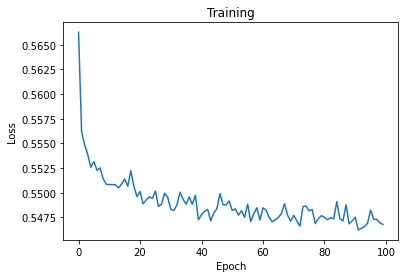

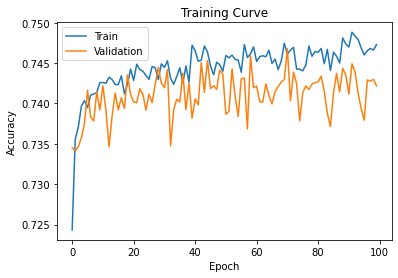

In [20]:
train(model, train_loader, test_loader, num_epochs=100, learning_rate=1e-2)